# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

<h1>Содержание</h1>
<li><span><a href="#Подготовка-данных" data-toc-modified-id="Подготовка-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка данных</a></span></li>
<li><span><a href="#Анализ-датасета" data-toc-modified-id="Анализ-датасета-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Анализ датасета</a></span></li>
<li><span><a href="#Предобработка-данных" data-toc-modified-id="Предобработка-данных-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Предобработка данных</a></span></li>
<li><span><a href="#Предобработка-данных-для-модели" data-toc-modified-id="Предобработка-данных-для-модели-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Предобработка данных для модели</a></span></li>
<li><span><a href="#Вывод-по-разделу" data-toc-modified-id="Вывод-по-разделу-1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>Вывод по разделу</a></span></li>
<li><span><a href="#Обучение-моделей" data-toc-modified-id="Обучение-моделей-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение моделей</a></span></li>
<li><span><a href="#Разбивка-данных-на-выборки" data-toc-modified-id="Разбивка-данных-на-выборки-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Разбивка данных на выборки</a></span></li>
<li><span><a href="#Обучение-простых-моделей" data-toc-modified-id="Обучение-простых-моделей-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Обучение простых моделей</a></span></li>
<li><span><a href="#Обучение-простых-моделей" data-toc-modified-id="Обучение-простых-моделей-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Обучение простых моделей</a></span></li>
<li><span><a href="#Обучение-модели-градиентного-бустинга" data-toc-modified-id="Обучение-модели-градиентного-бустинга-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Обучение модели градиентного бустинга</a></span></li>
<li><span><a href="#Анализ-моделей" data-toc-modified-id="Анализ-моделей-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Анализ моделей</a></span></li>
<li><span><a href="#Анализ-важности-признаков" data-toc-modified-id="Анализ-важности-признаков-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Анализ важности признаков</a></span></li>
<li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li>

## Подготовка данных
[К содержанию](#Содержание)

In [1]:
#библиотеки
import pandas as pd
import numpy as np
import lightgbm as lgb
#всякое
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
#модели
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from lightgbm import LGBMRegressor
#метрики
from sklearn.metrics import mean_squared_error
#константы
RS = 12345

### Анализ датасета
[К содержанию](#Содержание)

In [2]:
data = pd.read_csv('/datasets/autos.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
DateCrawled          354369 non-null object
Price                354369 non-null int64
VehicleType          316879 non-null object
RegistrationYear     354369 non-null int64
Gearbox              334536 non-null object
Power                354369 non-null int64
Model                334664 non-null object
Kilometer            354369 non-null int64
RegistrationMonth    354369 non-null int64
FuelType             321474 non-null object
Brand                354369 non-null object
NotRepaired          283215 non-null object
DateCreated          354369 non-null object
NumberOfPictures     354369 non-null int64
PostalCode           354369 non-null int64
LastSeen             354369 non-null object
dtypes: int64(7), object(9)
memory usage: 43.3+ MB


In [3]:
data

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354364,2016-03-21 09:50:58,0,NaN,2005,manual,0,colt,150000,7,petrol,mitsubishi,yes,2016-03-21 00:00:00,0,2694,2016-03-21 10:42:49
354365,2016-03-14 17:48:27,2200,NaN,2005,NaN,0,NaN,20000,1,NaN,sonstige_autos,NaN,2016-03-14 00:00:00,0,39576,2016-04-06 00:46:52
354366,2016-03-05 19:56:21,1199,convertible,2000,auto,101,fortwo,125000,3,petrol,smart,no,2016-03-05 00:00:00,0,26135,2016-03-11 18:17:12
354367,2016-03-19 18:57:12,9200,bus,1996,manual,102,transporter,150000,3,gasoline,volkswagen,no,2016-03-19 00:00:00,0,87439,2016-04-07 07:15:26


В данных много пропусков, необходима предобработка данных. Перед предобработкой сохраним исходный размер датасета чтобы сравнить, сколько данных мы в итоге потеряли.

In [4]:
data_init_shape = data.shape

In [5]:
data_init_shape

(354369, 16)

### Предобработка данных
[К содержанию](#Содержание)

Сначала проанализируем иимеющиеся признаки и обработаем их. Некоторым признакам уделим особое внимание и разберем досконально.

---
<i>DateCrawled — дата скачивания анкеты из базы</i> — никак не влияющий на цену признак, необходимый скорее для администрирования базы данных, мы его из нашего набора удалим.

In [6]:
data = data.drop(['DateCrawled'], axis=1)

---
<i>VehicleType — тип автомобильного кузова</i> — безусловно влияющий на цену признак.

In [7]:
data['VehicleType'].value_counts(dropna=False)

sedan          91457
small          79831
wagon          65166
NaN            37490
bus            28775
convertible    20203
coupe          16163
suv            11996
other           3288
Name: VehicleType, dtype: int64

Больше 10 процентов от всего набора данных это пропуски. Мне кажется, оптимальным решением будет поместить все неопределенные автомобили в категорию 'other'. Да, туда попадут разные автомобили вперемешку, но если наш пользователь захочет более точного определения стоимости, то ему придется немного потрудиться, точнее описывая своё авто. 

Изначально я думал, что можно будет восстановить часть данных ориентируясь на модель автомобиля. Однако, возможна ситуация, когда автомобиль одной и той же модели (к примеру, Форд Фокус) может быть и седаном и купе и кабриалетом.

In [8]:
data['VehicleType'] = data['VehicleType'].fillna('other')

---
<i>RegistrationYear — год регистрации автомобиля</i> — год и месяц регистрации автомобиля разумеется важны при определении цены, необходимо будет объеденить оба этих признака и изменить тип данных на Datetime. Однако, когда мы дойдем до <i>RegistrationMonth</i>, мы увидим, что у десяти процентов датасета вместо номера месяца стоит значение 0. Распределение регистраций по месяцам тоже не дает много информации.

0     37352
3     34373
6     31508
4     29270
5     29153
7     27213
10    26099
12    24289
11    24186
9     23813
1     23219
8     22627
2     21267
Name: RegistrationMonth, dtype: int64

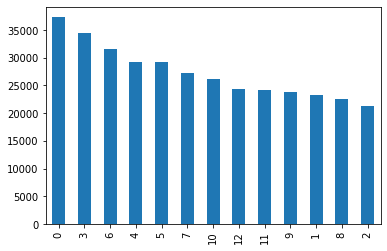

In [9]:
data['RegistrationMonth'].value_counts(dropna=False).plot(kind='bar')
data['RegistrationMonth'].value_counts(dropna=False)

Я вижу, что большая часть регистраций происходит с марта по июль. Не вижу особого смысла задумываться, с чем это связано, это не поможет нам распределить данные "нулевого" месяца верно. Так что я решил игнорировать месяц регистрации полностью. Мы отбросим этот признак из набора данных.

In [10]:
data = data.drop(['RegistrationMonth'], axis=1)

Теперь вернемся к году регистрации, с ним тоже не все так просто. Пропусков в этом признаке у нас, к счастью, не было. Однако надо проверить на ошибочно введенные года. Регистрация автомобилей в принципе началась а начале 20 века, посмотрим, на всё, что указывали пользователи, что было раньше.

In [11]:
data[data['RegistrationYear'] < 1900]['RegistrationYear'].value_counts(dropna=False)

1000    37
1500     5
1800     5
1234     4
1111     3
1600     2
1300     2
1400     1
1001     1
1255     1
1253     1
1602     1
1200     1
1688     1
1039     1
Name: RegistrationYear, dtype: int64

Очевидно, это не года регистрации. Люди просто не знали год и писали ерунду. Всего у нас таких годов 66. на фоне нашего набора данных их очень мало, я считаю, их можно просто отбросить. Теперь к чрезвычайно высоким годам. Посмоторим, когда была создана самая последняя анкета в нашем наборе данных.

In [12]:
data['DateCreated'].max()

'2016-04-07 00:00:00'

2016 год. По хорошему, после этого года у нас не может быть зарегистрированных автомобилей в наборе данных.

In [13]:
data[data['RegistrationYear'] > 2016]['RegistrationYear'].value_counts(dropna=False)

2017    10441
2018     3959
9999       26
2019       25
5000       17
3000        7
6000        5
7000        4
2500        4
4000        3
9000        3
5911        2
5555        2
4500        2
2800        2
2222        2
8000        2
4800        1
5600        1
7500        1
3200        1
9229        1
2200        1
9996        1
3800        1
7800        1
2066        1
2290        1
8455        1
7100        1
8200        1
8888        1
2900        1
3500        1
3700        1
4100        1
5300        1
9450        1
5900        1
6500        1
8500        1
Name: RegistrationYear, dtype: int64

Однако, мы видим ощутимое количество автомобилей, зарегистрированных в 2017 году и даже в 2018. Данные по 2019 году уже выглядят как погрешность.

Автомобили с 2017-2018 годами регистрации могли возникнуть по многим причинам. Например, могла элементарно на 1 или 2 года сбиться дата на сервере с базой данных. Тогда все регистрационные данные вносились бы со сдвигом на размер сбоя. Об этом лучше уточнить у команды, собирающей данные, чтобы они проверили время на той машине.

Кроме того, пользователи по тем или иным причинам могли указывать более поздние года например, если автомобиль планировался к выпуску на будущий год. Как мы выясним далее, достаточно большое количество сделок судя по всему будет выполняться диллерами Opel, и возможно в таком случае автомобиль еще не зарегистрирован, но уже продается по предзаказу.

Точно проверить мы это не можем, однако я считаю отказываться от куска данных за 2017-2018 года нельзя, слишком он большой. Поэтому отбросим данные после них.

In [14]:
data = data.drop(data[(data['RegistrationYear'] < 1900) | (data['RegistrationYear'] > 2018)].index, axis=0)

---
<i>Gearbox — тип коробки передач</i> — важный параметр автомобиля, влияющий на стоимость. В нем были пропуски, посмотрим, сколько их.

In [15]:
data['Gearbox'].value_counts(dropna=False)

manual    268211
auto       66273
NaN        19689
Name: Gearbox, dtype: int64

К сожалению, заполнить пропуски будет проблематично, на автомобиль одной и той же модели могли уставиться оба вида коробки передач. Поэтому тут я предлагаю сделать что-то похожее на то, как я поступил с типом кузова — поместить неопределенные данные в общую категорию 'undefined'. Таком образом если пользователь уточнит тип коробки передач, то модель сможет точнее подсказать ему цену. Но если этот признак будет неуказан, модель всё еще сможет дать предсказание, хоть и менее точное.

In [16]:
data['Gearbox'] = data['Gearbox'].fillna('undefined')

---
<i>Power — мощность (л. с.)</i> — важный параметр автомобиля, влияющий на стоимость. И хоть тут не было пропусков, надо проверить данные на ошибочность. Максимальная мощность современных серийных автомобилей в районе 1000 лошадиных сил. Однако, средняя мощность автомобиля в РФ всего 117 лошадинных сил ([источник](https://mag.auto.ru/article/statengpower/)). Я считаю, что можно взять как отметку 500 л. с. Так мы отбросим совсем сверхмощные ракетомобили, однако оставим место просто для очень мощных авто. Посмотрим, сколько строк данных мы теряем в таком случае.

In [17]:
data[data['Power'] > 500]['Power'].value_counts(dropna=False).sum()

448

Что ж, я готов списать менее 500 строк на ошибочные данные.

Теперь проверим, нижний предел. У меня отец ездит на старенькой Ниве, у которой что-то около 50 лошадиных сил. Предположим, что существуют автомобили в половину менее мощные и посмотрим на все, что останется.

In [18]:
data[data['Power'] < 20]['Power'].value_counts(dropna=False)

0     40085
5       103
18       51
1        32
4        30
11       28
12       22
15       20
14       20
10       15
19       14
7        11
6        11
16       10
2        10
3         8
17        8
8         7
13        7
9         5
Name: Power, dtype: int64

Сорок тысяч автомобилей с нулем вместо мощности и около 5 сотен автомобилей с мощностью менее 25 лошадиных сил. Я думаю, что тут надо поступить так же, как и с коробкой передач. Только чтобы не делать из числового признака категориальный, мы приравняем признак этих автомобилей к 0.

---
<i>Model — модель автомобиля</i> — важный параметр автомобиля, влияющий на стоимость, оставляем.

In [19]:
data['Model'].value_counts(dropna=False)

golf                  29218
other                 24402
3er                   19756
NaN                   19625
polo                  13062
                      ...  
serie_2                   8
serie_3                   4
rangerover                4
serie_1                   2
range_rover_evoque        2
Name: Model, Length: 251, dtype: int64

И снова одна из лидирующих категорий 'other'. А кроме нее еще и 5% датасета пропусков. Прилепим пропуски в прочие, так как не имеем возможности установить модель автомобиля. 

In [20]:
data['Model'] = data['Model'].fillna('other')

---
<i>Kilometer — пробег (км)</i> — важный параметр автомобиля, влияющий на стоимость, оставляем. Кроме того обратим внимание, как написано слово "километр". Быстрое гугление говорит, что:
> The British spelling is kilometre. The American spelling is kilometer.

Однако, в США применяется не метрическая система, и в описании автомобиля там скорее были бы мили. Возможно, слово в заголовке столбца написано не на английском языке. Пропусков тут не было, однако необходимо проверить данные на ошибочные.

In [21]:
data['Kilometer'].value_counts(dropna=False)

150000    238192
125000     36451
100000     14880
90000      11566
80000      10047
70000       8592
60000       7444
5000        6286
50000       6232
40000       4911
30000       4435
20000       3973
10000       1164
Name: Kilometer, dtype: int64

Очень интересное распределение по возрастанию. Выбивается только значение 5000. Возможно, в этой категории как раз новые салонные автомобили.

---
<i>RegistrationMonth — месяц регистрации автомобиля</i> — Этот параметр мы обработали и удалили ранее, смотри <i>RegistrationYear</i>.


---
<i>FuelType — тип топлива</i> — важный параметр автомобиля, влияющий на стоимость. Посомтрим на то, какие типы топлива имеем.

In [22]:
data['FuelType'].value_counts(dropna=False)

petrol      216311
gasoline     98708
NaN          32757
lpg           5310
cng            563
hybrid         233
other          201
electric        90
Name: FuelType, dtype: int64

Интнресно. Интересного так много, что распишем по пунктам:
* Первые два вида топлива, petrol и gasoline это британское и американское названия одного и того же бензина, здесь они прописаны отдельно и доля каждого значительна.
* Я ожидал увидеть третьим пунктом дизельное топливо, однако его вообще нет, похоже, что оно попало в одну из первый двух категорий. Однако гугление на эту тему мне не помогло, petrol и gasoline это одно и то же топливо, disel — совершенно другое. У меня есть версия, что дизельные топлива попали в категорию petrol, так как наиболее популярный источник дизтоплива это нефть (англ. petroleum). Хорошо бы связаться с источником датасета и уточнить, куда они записывали дизельные автомобили.
* Снова у нас огромное число пропусков. Там может быть что угодно, в том числе и пропавшее дизтопливо. Однако, не зная наверняка, мы можем только записать пропуски в 'other'.
* Так мало электромобилей и гибридов. Датасет не самый новый. Я уверен в аналогичном датасете текущего года доля гибридных и электроавтомобилей будет гораздо выше. Для того, чтобы актуально оценивать стоимость нашим клиентам сейчас, нам нужен будет более свежий датасет.

Итак, выполним все, о чем проговорили выше. Объеденим 'petrol' и 'gasoline' в одну категорию, пусть это будет 'petrol', она изначально больше. Все пропуски передадим в категорию 'other'.

In [23]:
data.loc[data.loc[data.loc[:,'FuelType'] == 'gasoline'].index,'FuelType'] = 'petrol'
data['FuelType'] = data['FuelType'].fillna('other')

---
<i>Brand — марка автомобиля</i> — Один из самых важных параметров, определяющих стоимость. Пропусков в этом признаке не было, посмотрим, с чем имеем дело.

In [24]:
data['Brand'].value_counts(dropna=False)

volkswagen        76972
opel              39913
bmw               36899
mercedes_benz     32031
audi              29450
ford              25173
renault           17922
peugeot           10996
fiat               9636
seat               6906
mazda              5609
skoda              5498
smart              5246
citroen            5145
nissan             4941
toyota             4606
hyundai            3585
sonstige_autos     3333
volvo              3210
mini               3201
mitsubishi         3019
honda              2816
kia                2464
suzuki             2323
alfa_romeo         2310
chevrolet          1752
chrysler           1438
dacia               900
daihatsu            806
subaru              759
porsche             756
jeep                676
trabant             585
land_rover          544
daewoo              542
saab                525
jaguar              505
rover               485
lancia              471
lada                225
Name: Brand, dtype: int64

Ну, во-первых, первые пять позицией и 60% всего датасета — немецкие автопроизводители. Американцев и японцев почти нет. Уж не на немецком авторынке составлен датасет? Все марки более-менее понятны и знакомы, кроме 'sonstige_autos'. Гугл-переводчик подсказывает, что 'sonstiges' с немецкого 'разные, прочие'. Что ж, дело раскрыто. Перед нами действительно датасет некоего немецкого сайта автообъявлений. Ничего особенного со списком марок автомобилей сделать нельзя, разве что изменим 'sonstige_autos' на интуитивно более понятное 'other'.

In [25]:
data.loc[data.loc[data.loc[:,'Brand'] == 'sonstige_autos'].index,'Brand'] = 'other'

---
<i>NotRepaired — была машина в ремонте или нет</i> — важный параметр автомобиля, влияющий на стоимость. Посомтрим, как распределены значения.

In [26]:
data['NotRepaired'].value_counts(dropna=False)

no     247132
NaN     70998
yes     36043
Name: NotRepaired, dtype: int64

И снова пропуски, почти 20% датасета. Прийдется присвоить им третью категорию 'undefined', аналогично тому, как мы поступили с коробкой передач.

In [27]:
data['NotRepaired'] = data['NotRepaired'].fillna('undefined')

---
<i>DateCreated — дата создания анкеты</i> — важный параметры, непосредственно не влияющий на стоимость конкретного автомобиля, но отражающий ситуацию на автомобильном рынке на момент создания анкеты. Два одинаковых автомобиля сейчас и пять лет назад будут стоить по разному. Самым правильным вариантом по моему мнению будет оставить из этих данных только год, модель регулярно дообучать на актуальных данных, а при использовании модели пользователем, автоматически использовать текущий год.

In [28]:
data['DateCreated'] = pd.to_datetime(data['DateCreated'], format='%Y-%m-%d %H:%M:%S')
data['DateCreated'] = data['DateCreated'].dt.year

---
<i>NumberOfPictures — количество фотографий автомобиля</i> — параметр, возможно влияющий на скорость продажи автомобиля, популярность объявления, но никак не определяющий стоимость, удалить

In [29]:
data = data.drop(['NumberOfPictures'], axis=1)

---
<i>PostalCode — почтовый индекс владельца анкеты (пользователя)</i> — интересный признак,  может указывать на место продажи автомобиля, а значит косвенно влиять на цену. Во-первых, в каком-то конкретном месте может быть большое предложение, а следовательно цена ниже. Во-вторых, место может быть ближе к месту поставки авто. Чтобы было понятнее, приведу пример: некая абстрактная Toyota продаваемая во Владивостоке будет стоить дешевле, чем идентичная по всем остальным параметрам машина, продаваемая во Владикавказе.
Взглянем на то, как у нас распределены признаки

10115    818
65428    613
66333    343
32257    317
44145    317
        ... 
94359      1
82279      1
4685       1
91801      1
31096      1
Name: PostalCode, Length: 8143, dtype: int64

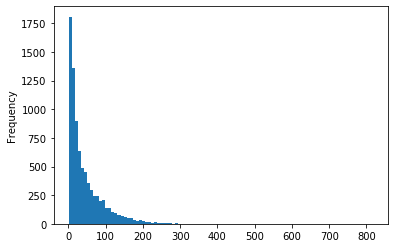

In [30]:
data['PostalCode'].value_counts().plot(kind='hist', bins=100)
data['PostalCode'].value_counts()

Есть некоторое количество индексов, по которым продается довольно много автомобилей. Погуглим их. Как мы помним, датасет у нас был немецким, так что скорее всего индексы будут находиться именно в Германии.
10115 — гугл выдает два адреса - офисное здание на Манхэттене и целый район в центре Берлина.
Попробуем следующий индекс.
65428 — первая же ссылка на википедию, на статью о населенном пункте Rüsselsheim am Main. Читаем.
>Rüsselsheim has attained international recognition through the presence of the German car company Opel.

Дело раскрыто, в Рюссельсхайме расположена штаб-квартира автокомпании Opel. Следовательно, большинство авто, продаваемых по данному индексу будут автомобили этой марки. Проверим эту гипотезу.

In [31]:
data[data['PostalCode'] == 65428]['Brand'].value_counts().head(10)

opel             200
volkswagen       105
bmw               78
mercedes_benz     58
audi              28
fiat              23
ford              20
renault           17
peugeot           15
smart              9
Name: Brand, dtype: int64

Не подавляющее большинство, но всё же марка самая популярная. Из этого делаю вывод, что большинство популярных почтовых кодов продавцов соответствуют штабквартирам производителей, крупным авторынкам или просто крупным населенным пунктам, где идет активная торговля автомобилями. Как я уже писал, этот признак мог бы иметь большую важность, если бы в датасете была представлена протяженная страна, в которой в разных регионах преобладают авто разных марок, например в России. Однако В Германии место продажи авто не так сильно влияет на его стоимость. Кроме того, если мы планируем использовать модель для пользователей из РФ с местными почтовыми индексами, модель и вовсе будет "показывать погоду". Поэтому, признак лучше всё же удалить.

In [32]:
data = data.drop(['PostalCode'], axis=1)

---
<i>LastSeen — дата последней активности пользователя</i> — признак, совершенно нам не нужный. Удалить!

In [33]:
data = data.drop(['LastSeen'], axis=1)

---
И конечно рассмотрим целевой признак.

<i>Price — цена (евро)</i> — так как это цена и вариантов цен может быть очень много, используем гистограму, чтобы понять, как у нас распределены цены.

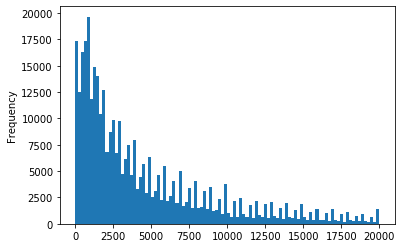

In [34]:
data['Price'].plot(kind='hist', bins=100)

Вполне ожидаемое распределение, больше всего на рынке дешевых машин, чем выше цена, тем меньше автомобилей представлено. Выдающиеся над графиком "пики" это какие-то круглые цены, к которым люди округляют свою цену (напр. 5000, 10 000, 11 500).

Верхний предел цен в датасете 20 000 евро. На самом деле не так то и много, для автомобиля. Вряд ли тут есть какие-то люксовые очень мощные автомобили. Возможно, если бы я лучше разбирался в авторынке, нужно было бы пересмотреть признак 'Power' - 'Мощность'. Врядли автомобили мощностью в 500 лошадиных сил будут стоить 20 000 евро и меньше.

Кроме того, очень много автомобилей выставлено за цену в 0 евро. Вряд ли на авторынке германии столько меценатов, и сомневаюсь, что так много людей ошибались в таком важном моменте, как указание цены на продаваемое авто. Скорее всего цена или еще не определена или устанавливалась в ходе торгов. Нам эти данные будут только мешать. Кроме того, попробуем отсеять самые дешевые автомобили, так как я уверен, там или автомобили в совсем плачевном состоянии или ошибочные цены. Отбросим, к примеру 5% самых дешевых авто. Для начала найдем соответствующий процентиль.

In [35]:
data['Price'].describe(percentiles=[.05, .25, .5, .75, .95])

count    354173.000000
mean       4417.739698
std        4514.026054
min           0.000000
5%          200.000000
25%        1050.000000
50%        2700.000000
75%        6400.000000
95%       14600.000000
max       20000.000000
Name: Price, dtype: float64

Ровно 200 евро. Теперь удалим из датасета записи с автомобилями такой цены.

In [36]:
data = data.drop(data[data['Price'] <= 200].index, axis=0)

И после всех удалений сбросим индексы датасета.

In [37]:
data = data.reset_index(drop=True)

### Предобработка данных для модели
[К содержанию](#Содержание)

Для того, чтобы модели могли обрабатывать категориальные признаки, преобразуем их, используя OrdinalEncoder(). Именно его потому, что в некоторых признаках у нас много очень много категорий (напр. марка и модель авто) и OHE раскукожит нам набор данных до безобразия.

In [38]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 334807 entries, 0 to 334806
Data columns (total 11 columns):
Price               334807 non-null int64
VehicleType         334807 non-null object
RegistrationYear    334807 non-null int64
Gearbox             334807 non-null object
Power               334807 non-null int64
Model               334807 non-null object
Kilometer           334807 non-null int64
FuelType            334807 non-null object
Brand               334807 non-null object
NotRepaired         334807 non-null object
DateCreated         334807 non-null int64
dtypes: int64(5), object(6)
memory usage: 28.1+ MB


In [39]:
categorial = ['VehicleType', 'Gearbox','Model','FuelType','Brand','NotRepaired']

In [40]:
data_lgbm = data
data_lgbm[categorial] = data_lgbm[categorial].astype('category')

In [41]:
encoder = OrdinalEncoder()

encoder.fit(data[categorial]) 

data[categorial] = pd.DataFrame(encoder.transform(data[categorial]), columns=categorial)

### Вывод по разделу
[К содержанию](#Содержание)

Мы подготовили датасет работе с моделями и попутно выяснили много полезной информации.

1. Датасет подготовлен на данных, собранных в одной конкретной локации (Германия), и не подойдет для применения в коммерческих целях в другой локации (Россия).
2. Кроме того, в датасете была информация о почтовом индексе продавца, которая могла бы быть актуальна в России из-за высокой протяженности и как следствие ощутимого разброса цен в разных концах страны. Однако, данные по германии для этих целей увы применять нельзя.
3. Датасет выгружен весной 2016 года и содержит не актуальные на сегодняшний день данные.

Всё это простительно, так как проект у нас учебный.

Посомтрим, какие данные мы получили после предобработки.

In [42]:
data

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,NotRepaired,DateCreated
0,480,3.0,1993,1.0,0,116.0,150000,5.0,38.0,1.0,2016
1,18300,2.0,2011,1.0,190,166.0,125000,5.0,1.0,2.0,2016
2,9800,6.0,2004,0.0,163,117.0,125000,5.0,14.0,1.0,2016
3,1500,5.0,2001,1.0,75,116.0,150000,5.0,38.0,0.0,2016
4,3600,5.0,2008,1.0,69,101.0,90000,5.0,32.0,0.0,2016
...,...,...,...,...,...,...,...,...,...,...,...
334802,1150,0.0,2000,1.0,0,249.0,150000,5.0,24.0,0.0,2016
334803,2200,3.0,2005,2.0,0,166.0,20000,4.0,25.0,1.0,2016
334804,1199,1.0,2000,0.0,101,106.0,125000,5.0,33.0,0.0,2016
334805,9200,0.0,1996,1.0,102,224.0,150000,5.0,38.0,0.0,2016


In [43]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 334807 entries, 0 to 334806
Data columns (total 11 columns):
Price               334807 non-null int64
VehicleType         334807 non-null float64
RegistrationYear    334807 non-null int64
Gearbox             334807 non-null float64
Power               334807 non-null int64
Model               334807 non-null float64
Kilometer           334807 non-null int64
FuelType            334807 non-null float64
Brand               334807 non-null float64
NotRepaired         334807 non-null float64
DateCreated         334807 non-null int64
dtypes: float64(6), int64(5)
memory usage: 28.1 MB


Посмотрим, какую часть данных потеряли при предобработке.

In [44]:
(1 - data.shape[0] / data_init_shape[0]) * 100

5.520234557763237

Всего около пяти с половиной процентов данных. Кроме того, размер нашего датасета уменьшился с 43.3 мегабайт до 28.1 мегабайта.

## Обучение моделей
[К содержанию](#Содержание)

### Разбивка данных на выборки
[К содержанию](#Содержание)

Для работы с моделями нам необходимо сначала разбить данные на признаки и целевой признак.

In [45]:
features = data.drop(['Price'], axis=1)
target = data['Price']

А теперь поделить наборы данных их на учебный и валидационный.

In [46]:
features_train_valid, features_test, target_train_valid, target_test = train_test_split(
    features,
    target,
    test_size=.20,
    random_state=RS)

In [47]:
features_train, features_valid, target_train, target_valid = train_test_split(
    features_train_valid,
    target_train_valid,
    test_size=.25,
    random_state=RS)

### Обучение простых моделей
[К содержанию](#Содержание)

Прежде чем применять градиентный бустинг, обучим простые модели и посомтрим, как они себя покажут. Там, где это возможно, обучать модели будем в циклах, подбирая оптимальные гиперпараметры. Перед подбором гиперпараметров, обучим модели без подбора, чтобы понять сколько времени займет обучение и предсказание каждой из моделей.

#### Модель линейной регрессии

In [48]:
model_linreg = LinearRegression()

In [49]:
%%time

model_linreg.fit(features_train_valid, target_train_valid)

CPU times: user 74.2 ms, sys: 41.7 ms, total: 116 ms
Wall time: 87.5 ms


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [50]:
%%time

predictions = model_linreg.predict(features_test)

CPU times: user 13.2 ms, sys: 4.26 ms, total: 17.5 ms
Wall time: 74.1 ms


In [51]:
rmse = np.sqrt(mean_squared_error(target_test, predictions))
print('При использовании модели линейной регрессии, результат метрики RMSE: {:.1f}.'.format(rmse))

При использовании модели линейной регрессии, результат метрики RMSE: 3633.4.


Время обучения модели линейной регрессии на наших данных: 87.5 ms  
Время предсказаний модели линейной регрессии: 74.1 ms

#### Модель древа решений

In [52]:
model_tree = DecisionTreeRegressor(random_state = RS)

In [53]:
%%time

model_tree.fit(features_train_valid, target_train_valid)

CPU times: user 1.07 s, sys: 870 µs, total: 1.07 s
Wall time: 1.08 s


DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=12345, splitter='best')

In [54]:
%%time

predictions = model_tree.predict(features_test)

CPU times: user 40.5 ms, sys: 517 µs, total: 41 ms
Wall time: 39.2 ms


In [55]:
rmse = np.sqrt(mean_squared_error(target_test, predictions))
rmse

2019.3475617080824

Время обучения модели древа решений на наших данных: 1.08 s  
Время предсказаний модели древа решений: 39.2 ms

In [56]:
%%time

best_depth = 0
best_rmse = 10000
for depth in range(5, 20):
    model_tree = DecisionTreeRegressor(max_depth = depth, random_state = RS)
    model_tree.fit(features_train, target_train)
    predictions = model_tree.predict(features_valid)
    rmse = np.sqrt(mean_squared_error(target_valid, predictions))
    if rmse < best_rmse:
        best_rmse = rmse
        best_depth = depth
        
model_tree = DecisionTreeRegressor(max_depth = best_depth, random_state = RS)
model_tree.fit(features_train, target_train)
predictions = model_tree.predict(features_test)
rmse = np.sqrt(mean_squared_error(target_test, predictions))
print('При использовании модели древа решений, наилучший результат метрики RMSE: {:.1f}\nпри значении гиперпараметра модели "max_depth={:.0f}".'.format(rmse, best_depth))

При использовании модели древа решений, наилучший результат метрики RMSE: 1961.3
при значении гиперпараметра модели "max_depth=14".
CPU times: user 7.41 s, sys: 0 ns, total: 7.41 s
Wall time: 7.74 s


In [57]:
%%time

parameters = {'max_depth': range(5,20)}
clf = GridSearchCV(DecisionTreeRegressor(), parameters, cv=5, scoring='neg_mean_squared_error')
clf.fit(features_train_valid, target_train_valid)
print(clf.best_params_)

model_tree = DecisionTreeRegressor(max_depth = clf.best_params_['max_depth'], random_state = RS)
model_tree.fit(features_train_valid, target_train_valid)
predictions = model_tree.predict(features_test)
rmse = np.sqrt(mean_squared_error(target_test, predictions))
    
print('RMSE равен', rmse)

{'max_depth': 14}
RMSE равен 1933.7844754252167
CPU times: user 39.4 s, sys: 526 ms, total: 39.9 s
Wall time: 40.3 s


#### Модель случайного леса

In [58]:
model_forest = RandomForestRegressor(random_state = RS)

In [59]:
%%time

model_forest.fit(features_train_valid, target_train_valid)

/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


CPU times: user 6.9 s, sys: 55.7 ms, total: 6.96 s
Wall time: 6.98 s


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=10,
                      n_jobs=None, oob_score=False, random_state=12345,
                      verbose=0, warm_start=False)

In [60]:
%%time

predictions = model_forest.predict(features_test)

CPU times: user 329 ms, sys: 0 ns, total: 329 ms
Wall time: 340 ms


In [61]:
rmse = np.sqrt(mean_squared_error(target_test, predictions))
rmse

1697.4706818558889

Время обучения модели случайного леса на наших данных: 6.98 s  
Время предсказаний модели случайного леса: 340 ms

In [62]:
%%time

best_depth = 0
best_es = 0
best_rmse = 10000
for depth in range(15, 25):
    for es in range(5, 15):
        model_forest = RandomForestRegressor(max_depth = depth, n_estimators = es, random_state = RS)
        model_forest.fit(features_train, target_train)
        predictions = model_forest.predict(features_valid)
        rmse = np.sqrt(mean_squared_error(target_valid, predictions))
        if rmse < best_rmse:
            best_rmse = rmse
            best_depth = depth
            best_es = es

model_forest = RandomForestRegressor(max_depth = best_depth, n_estimators = best_es, random_state = RS)
model_forest.fit(features_train, target_train)
predictions = model_forest.predict(features_test)
rmse = np.sqrt(mean_squared_error(target_test, predictions))

print('При использовании модели случайного леса, наилучший результат метрики RMSE: {:.1f}\nпри значении гиперпараметров модели "max_depth={:.0f}", "n_estimators={:.0f}".'.format(rmse, best_depth, best_es))

При использовании модели случайного леса, наилучший результат метрики RMSE: 1705.4
при значении гиперпараметров модели "max_depth=18", "n_estimators=14".
CPU times: user 7min 30s, sys: 1.59 s, total: 7min 31s
Wall time: 7min 33s


### Обучение модели градиентного бустинга
[К содержанию](#Содержание)

В этом проекте предлагается искользовать модели градиентного бустинга из библиотеки LightGBM.

In [63]:
features_lgbm = data_lgbm.drop(['Price'], axis=1)
target_lgbm = data_lgbm['Price']

In [64]:
features_lgbm_train_valid, features_lgbm_test, target_lgbm_train_valid, target_lgbm_test = train_test_split(
    features_lgbm,
    target_lgbm,
    test_size=.20,
    random_state=RS)

In [65]:
features_lgbm_train, features_lgbm_test, target_lgbm_train, target_lgbm_test = train_test_split(
    features_lgbm_train_valid,
    target_lgbm_train_valid,
    test_size=.25,
    random_state=RS)

#### LGBMRegressor

In [66]:
model_lgb = LGBMRegressor(random_state=RS)

In [67]:
%%time

model_lgb.fit(features_lgbm_train_valid, target_lgbm_train_valid)

CPU times: user 8.74 s, sys: 74.4 ms, total: 8.81 s
Wall time: 8.91 s


LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=-1,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
              random_state=12345, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [68]:
%%time

predictions = model_lgb.predict(features_lgbm_test)

CPU times: user 519 ms, sys: 46 µs, total: 519 ms
Wall time: 586 ms


In [69]:
rmse = np.sqrt(mean_squared_error(target_lgbm_test, predictions))
rmse

1757.2974135516313

Время обучения модели градиентного бустинга LGBMRegressor на наших данных: 8.91 s  
Время предсказаний модели градиентного бустинга LGBMRegressor: 586 ms

In [70]:
%%time

best_rate = 0
best_es = 0
best_rmse = 10000
for rate in range(25, 35, 5):
    for es in range(200, 401, 100):
        model_lgb = LGBMRegressor(n_estimators=es, learning_rate = rate/100,random_state=RS)
        model_lgb.fit(features_train, target_train)
        predictions = model_lgb.predict(features_valid)
        rmse = np.sqrt(mean_squared_error(target_valid, predictions))
        if rmse < best_rmse:
                best_rmse = rmse
                best_rate = rate
                best_es = es

model_lgb = LGBMRegressor(n_estimators=best_es, learning_rate = best_rate/100, random_state=RS)
model_lgb.fit(features_train, target_train)
predictions = model_lgb.predict(features_test)
rmse = np.sqrt(mean_squared_error(target_test, predictions))

print('При использовании модели градиентного бустинга из библиотеки LightGBM, наилучший результат метрики RMSE: {:.1f}\nпри значении гиперпараметров модели "learning_rate={:.2f}", "n_estimators={:.0f}".'.format(rmse, best_rate/100, best_es))

При использовании модели градиентного бустинга из библиотеки LightGBM, наилучший результат метрики RMSE: 1633.2
при значении гиперпараметров модели "learning_rate=0.25", "n_estimators=400".
CPU times: user 2min 1s, sys: 710 ms, total: 2min 2s
Wall time: 2min 4s


## Анализ моделей
[К содержанию](#Содержание)

Сведем результаты работы всех моделей в таблицу. Очевидно, что время работы может отличаться на разных машинах и при разной загружености. Поэтому фиксирую его здесь и сеййчас чтобы сделать какие-то выводы. 

Для того, чтобы было справедливо сравнивать время работы моделей, модели обучались и проверялись на одном и том же наборе данных train_valid и test. Единственное отличие — у модели градиентного бустинга иначе были обработаны категориальные признаки.

| Применяемая модель     | Время обучения | Время предсказания |  RMSE  |
|:-----------------------|---------------:|-------------------:|-------:|
| LinearRegression()     | 87.5 ms        | 74.1 ms            | 3633.4 |
| DecisionTreeRegressor()| 1.08 s         | 39.2 ms            | 2019.3 |
| RandomForestRegressor()| 6.98 s         | 340 ms             | 1697.4 |
| LGBMRegressor()        | 8.91 s         | 586 ms             | 1757.3 |


Из таблицы видно, что у более простых моделей гораздо меньше и время обучения и предсказания, однако при этом гораздо хуже метрика — больше ошибка. Тогда как ансамбль и модель градиентного бустинга дают гораздо меньшую ошибку, но время на обучение на одних и тех же данных может отличаться в десятки раз.
    
Однако, мы можем запустить те же самые алгоритмы на более производительных машинах. Это даст нам ту же самую ошибку за меньшее, приемлимое время.

В результате, без подбора гиперпараметров модель случайного леса и модель градиентного бустинга дают близкие результаты по качеству и скорости работы. 

При самом поверхностном переборе гиперпараметров, модель градинетного бустинга улучшает свои результаты и заметно опережает модель случайного леса.

Однако, перебор параметров для модели градинетного бустинга занимает гораздо больше времени. Когда в модели случайного леса было перебрано 100 возможных комбинаций двух гиперпараметров, модель градиентного бустинга примерно за то же время перебрала только 30 возможных комбинаций.

### Анализ важности признаков
[К содержанию](#Содержание)

Выполним анализ важности признаков у тех моделей, у которых это возможно сделать.

In [71]:
imp_tree = model_tree.feature_importances_
imp_forest = model_forest.feature_importances_
imp_lgb = model_lgb.feature_importances_
imp_lgb = imp_lgb/imp_lgb.sum()
importances = pd.DataFrame(index=['RandomTree', 'RandomForest', 'LightGBM'], columns=features_train.columns, data=[imp_tree, imp_forest, imp_lgb])
importances

,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,NotRepaired,DateCreated
RandomTree,0.030253,0.531229,0.006373,0.301524,0.023698,0.054453,0.001695,0.036212,0.014551,0.000013
RandomForest,0.034375,0.498147,0.010305,0.292953,0.039661,0.059836,0.004014,0.043883,0.016814,0.000011
LightGBM,0.077667,0.234750,0.031583,0.239250,0.154250,0.106250,0.014583,0.112750,0.028917,0.000000


В итоге, как видим, наибольшее влияние на стоимость автомобиля оказывает именно год регистрации автомобиля и мощность. Затем идут пробег и марка. Зная это, можно было бы вернуться к обработке данных и уделить больше внимания именно этим четырем признакам.

Дата создания почти никак не влияет на предсказания так как у нас датасет с очень малым диапазоном категорий в этом признаке. Думаю, если бы у нас были данные за десять лет, важность данного признака была бы выше.

Отдельно отметим на результаты модели градиентного бустинга. Она отвела гораздо больше веса таким признакам, как тип коробки передач и модель авто. Следовательно при предсказании данная модель ориентируется в том числе и на эти признаки. По идее это должно увеличивать качество предсказаний.